In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing as pp
from sklearn import tree

import matplotlib.pyplot as plt
import os
import math
import unittest

import torch
import torch.nn as nn
from torch.functional import F

os.makedirs('result', exist_ok=True)
plt.rcParams['font.sans-serif'] = 'simhei'  # 设置字体
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# 读入鸢尾花数据
iris_df = pd.read_csv('iris.csv' ,encoding='gbk', header=None)
# 重新设置数据列名
iris_df.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'category']
iris_df.head()

,sepal_length,sepal_width,petal_length,petal_width,category
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
x_real = iris_df.drop(columns=['category']).to_numpy()
y_real = iris_df['category'].to_numpy()
x_real.shape, y_real.shape

((150, 4), (150,))

In [4]:
# C4.5

class C45:

    """Creates a decision tree with C4.5 algorithm"""
    def __init__(self, pathToData, pathToNames):
        self.filePathToData = pathToData
        self.filePathToNames = pathToNames
        self.data = []
        self.classes = []
        self.numAttributes = -1 
        self.attrValues = {}
        self.attributes = []
        self.tree = None

    def fetchData(self):
        with open(self.filePathToNames, "r") as file:
            classes = file.readline()
            self.classes = [x.strip() for x in classes.split(",")]
            #add attributes
            for line in file:
                [attribute, values] = [x.strip() for x in line.split(":")]
                values = [x.strip() for x in values.split(",")]
                self.attrValues[attribute] = values
        self.numAttributes = len(self.attrValues.keys())
        self.attributes = list(self.attrValues.keys())
        with open(self.filePathToData, "r") as file:
            for line in file:
                row = [x.strip() for x in line.split(",")]
                if row != [] or row != [""]:
                    self.data.append(row)

    def preprocessData(self):
        for index,row in enumerate(self.data):
            for attr_index in range(self.numAttributes):
                if(not self.isAttrDiscrete(self.attributes[attr_index])):
                    self.data[index][attr_index] = float(self.data[index][attr_index])

    def printTree(self):
        self.printNode(self.tree)

    def printNode(self, node, indent=""):
        if not node.isLeaf:
            if node.threshold is None:
                # discrete
                for index,child in enumerate(node.children):
                    if child.isLeaf:
                        print(indent + node.label + " = " + attributes[index] + " : " + child.label)
                    else:
                        print(indent + node.label + " = " + attributes[index] + " : ")
                        self.printNode(child, indent + "    ")
            else:
                # numerical
                leftChild = node.children[0]
                rightChild = node.children[1]
                if leftChild.isLeaf:
                    print(indent + node.label + " <= " + str(node.threshold) + " : " + leftChild.label)
                else:
                    print(indent + node.label + " <= " + str(node.threshold)+" : ")
                    self.printNode(leftChild, indent + "    ")

                if rightChild.isLeaf:
                    print(indent + node.label + " > " + str(node.threshold) + " : " + rightChild.label)
                else:
                    print(indent + node.label + " > " + str(node.threshold) + " : ")
                    self.printNode(rightChild , indent + "    ")

    def generateTree(self):
        self.tree = self.recursiveGenerateTree(self.data, self.attributes)

    def recursiveGenerateTree(self, curData, curAttributes):
        allSame = self.allSameClass(curData)

        if len(curData) == 0:
            # Fail
            return Node(True, "Fail", None)
        elif allSame is not False:
            # return a node with that class
            return Node(True, allSame, None)
        elif len(curAttributes) == 0:
            # return a node with the majority class
            majClass = self.getMajClass(curData)
            return Node(True, majClass, None)
        else:
            (best,best_threshold,splitted) = self.splitAttribute(curData, curAttributes)
            remainingAttributes = curAttributes[:]
            remainingAttributes.remove(best)
            node = Node(False, best, best_threshold)
            node.children = [self.recursiveGenerateTree(subset, remainingAttributes) for subset in splitted]
            return node

    def getMajClass(self, curData):
        freq = [0]*len(self.classes)
        for row in curData:
            index = self.classes.index(row[-1])
            freq[index] += 1
        maxInd = freq.index(max(freq))
        return self.classes[maxInd]


    def allSameClass(self, data):
        for row in data:
            if row[-1] != data[0][-1]:
                return False
        return data[0][-1]

    def isAttrDiscrete(self, attribute):
        if attribute not in self.attributes:
            raise ValueError("Attribute not listed")
        elif len(self.attrValues[attribute]) == 1 and self.attrValues[attribute][0] == "continuous":
            return False
        else:
            return True

    def splitAttribute(self, curData, curAttributes):
        splitted = []
        maxEnt = -1*float("inf")
        best_attribute = -1
        # None for discrete attributes, threshold value for continuous attributes
        best_threshold = None
        for attribute in curAttributes:
            indexOfAttribute = self.attributes.index(attribute)
            if self.isAttrDiscrete(attribute):
                # split curData into n-subsets, where n is the number of 
                # different values of attribute i. Choose the attribute with
                # the max gain
                valuesForAttribute = self.attrValues[attribute]
                subsets = [[] for a in valuesForAttribute]
                for row in curData:
                    for index in range(len(valuesForAttribute)):
                        if row[i] == valuesForAttribute[index]:
                            subsets[index].append(row)
                            break
                e = gain(curData, subsets)
                if e > maxEnt:
                    maxEnt = e
                    splitted = subsets
                    best_attribute = attribute
                    best_threshold = None
            else:
                # sort the data according to the column.Then try all 
                # possible adjacent pairs. Choose the one that 
                # yields maximum gain
                curData.sort(key = lambda x: x[indexOfAttribute])
                for j in range(0, len(curData) - 1):
                    if curData[j][indexOfAttribute] != curData[j+1][indexOfAttribute]:
                        threshold = (curData[j][indexOfAttribute] + curData[j+1][indexOfAttribute]) / 2
                        less = []
                        greater = []
                        for row in curData:
                            if(row[indexOfAttribute] > threshold):
                                greater.append(row)
                            else:
                                less.append(row)
                        e = self.gain(curData, [less, greater])
                        if e >= maxEnt:
                            splitted = [less, greater]
                            maxEnt = e
                            best_attribute = attribute
                            best_threshold = threshold
        return (best_attribute,best_threshold,splitted)

    def gain(self, unionSet, subsets):
        # input : data and disjoint subsets of it
        # output : information gain
        S = len(unionSet)
        # calculate impurity before split
        impurityBeforeSplit = self.entropy(unionSet)
        # calculate impurity after split
        weights = [len(subset)/S for subset in subsets]
        impurityAfterSplit = 0
        for i in range(len(subsets)):
            impurityAfterSplit += weights[i]*self.entropy(subsets[i])
        # calculate total gain
        totalGain = impurityBeforeSplit - impurityAfterSplit
        return totalGain

    def entropy(self, dataSet):
        S = len(dataSet)
        if S == 0:
            return 0
        num_classes = [0 for i in self.classes]
        for row in dataSet:
            classIndex = list(self.classes).index(row[-1])
            num_classes[classIndex] += 1
        num_classes = [x/S for x in num_classes]
        ent = 0
        for num in num_classes:
            ent += num*self.log(num)
        return ent*-1


    def log(self, x):
        if x == 0:
            return 0
        else:
            return math.log(x,2)
    
    def predict(self, features):
        return self.predictNode(features, self.tree)
    
    
    def predictNode(self, features, node):
        if not node.isLeaf:
            # numerical
            leftChild = node.children[0]
            rightChild = node.children[1]
            if features[node.label] <= node.threshold:
                return self.predictNode(features, leftChild)
            else:
                return self.predictNode(features, rightChild)
        else:
            return node.label

class Node:
    def __init__(self, isLeaf, label, threshold):
        self.label = label
        self.threshold = threshold
        self.isLeaf = isLeaf
        self.children = []

In [5]:
dtc = C45("iris.csv", "iris.txt")
dtc.fetchData()
dtc.preprocessData()
dtc.generateTree()
dtc.printTree()

petal width <= 0.8 : Iris-setosa
petal width > 0.8 : 
    petal length <= 4.75 : 
        sepal length <= 4.95 : 
            sepal width <= 2.45 : Iris-versicolor
            sepal width > 2.45 : Iris-virginica
        sepal length > 4.95 : Iris-versicolor
    petal length > 4.75 : 
        sepal length <= 7.0 : 
            sepal width <= 3.25 : Iris-virginica
            sepal width > 3.25 : Iris-virginica
        sepal length > 7.0 : Iris-virginica


In [6]:
dtc_result = []
for x in x_real:
    data = {'sepal length': x[0], 'sepal width': x[1], 'petal length': x[2], 'petal width': x[3]}
    dtc_result.append(dtc.predict(data))


In [7]:
# Pytorch
class Net(nn.Module):
    def __init__(self, x_features = 4, classes = 3, lr = 0.001):
        super(Net, self).__init__()
        self.classes = classes
        self.x_features = x_features
        
        self.fc = nn.Sequential(
            nn.Linear(self.x_features, 4),
            nn.Sigmoid(),
            nn.Linear(4, 4),
            nn.Sigmoid(),
            nn.Linear(4, self.classes),
        )
        self.mls = nn.CrossEntropyLoss()
        self.opt = torch.optim.Adam(params=self.parameters(), lr=lr)
    
    def forward(self, inputs):
        out = self.fc(inputs)
        return out

    def train(self, x_, label_):
        total_loss = 0.0
        for itr, x in enumerate(x_):
            x = torch.from_numpy(x).float().reshape(1, -1)
            label = torch.Tensor(label_[itr].reshape(-1,)).long()
            
            out = self.forward(x)
            # print(out)
            loss = self.mls(out, label)
            total_loss += loss.item()
            self.opt.zero_grad()
            loss.backward()
            self.opt.step()
        return total_loss

    def test(self, x_):
        res = []
        for itr, x in enumerate(x_):
            x = torch.from_numpy(x).float()
            out = self.forward(x)
            # print(out)
            _, out = out.data.max(0)
            # print(out)
            res.append(out.data)
        
        return res
        

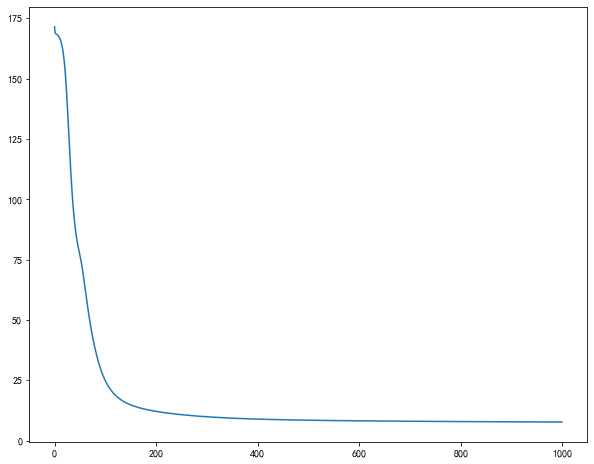

In [8]:
model = Net()
epochs = 1000

id2cat = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
cat2id = {'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2}

scaler = pp.MinMaxScaler(feature_range=(0, 1))
x = scaler.fit_transform(x_real)
y = np.array([cat2id[_] for _ in y_real]).reshape(-1, 1)
# one_hot_encoder = pp.OneHotEncoder()
# y = one_hot_encoder.fit_transform(y).toarray()

loss = []
for i in range(epochs):
    loss.append(model.train(x, y))
    
plt.figure(figsize=(10, 8))
plt.plot(range(len(loss)), loss)
nn_result = model.test(x_real)

In [9]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_real, y_real)
sktree_result = clf.predict(x_real)

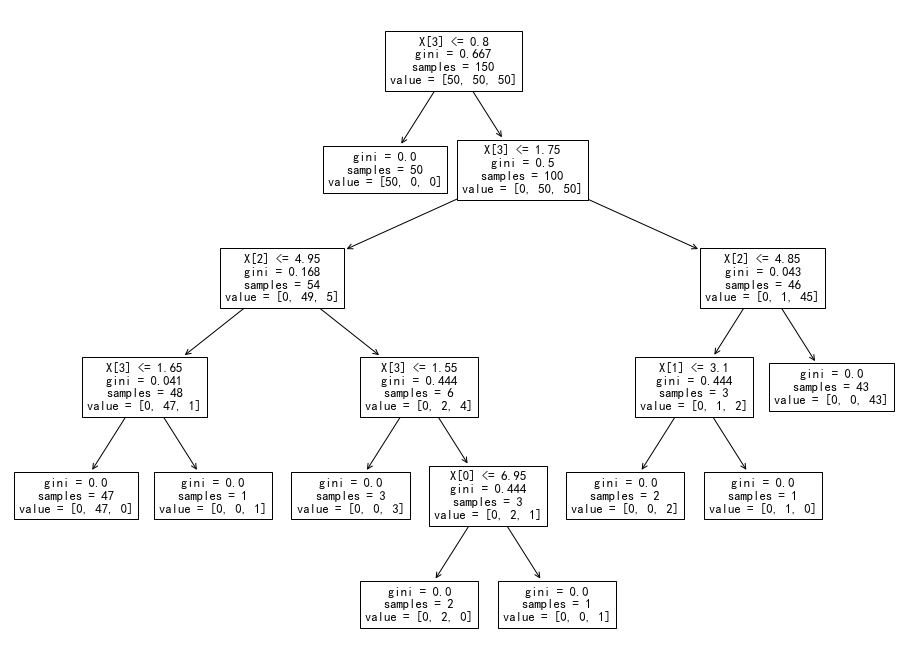

In [10]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot()
tree.plot_tree(clf, ax=ax)
plt.savefig(os.path.join('result', 'sklearn_tree.png'))
plt.show()

In [11]:
# print(dtc_result[:5])
# print(nn_result[:5])
# print(sktree_result[:5])


dtc_acc = 0
nn_acc = 0
sktree_acc = 0
for idx, pred_y in enumerate(y_real):
    if dtc_result[idx] == pred_y:
        dtc_acc += 1
    if nn_result[idx].data == y[idx][0]:
        nn_acc += 1
    if sktree_result[idx] == pred_y:
        sktree_acc += 1

dtc_acc /= len(dtc_result)
nn_acc /= len(nn_result)
sktree_acc /= len(sktree_result)

print(f'C4.5准确率：{dtc_acc}')
print(f'NN准确率：{nn_acc}')
print(f'sklearn决策树准确率：{sktree_acc}')

C4.5准确率：0.96
NN准确率：0.6666666666666666
sklearn决策树准确率：1.0


In [12]:
# Pytorch
class BNet(nn.Module):
    def __init__(self, x_features = 4, classes = 1, lr = 0.001):
        super(BNet, self).__init__()
        self.classes = classes
        self.x_features = x_features
        
        self.fc = nn.Sequential(
            nn.Linear(self.x_features, 4),
            nn.Sigmoid(),
            nn.Linear(4, 4),
            nn.Sigmoid(),
            nn.Linear(4, self.classes),
            nn.Sigmoid()
        )
        self.mls = nn.BCELoss()
        self.opt = torch.optim.Adam(params=self.parameters(), lr=lr)
    
    def forward(self, inputs):
        out = self.fc(inputs)
        return out.squeeze(dim=-1)

    def train(self, x_, label_):
        total_loss = 0.0
        for itr, x in enumerate(x_):
            x = torch.from_numpy(x).float().reshape(1, -1)
            label = torch.Tensor(label_[itr].reshape(-1))
            # print(label.size())
            out = self.forward(x)
            # print(out.size())
            loss = self.mls(out, label)
            total_loss += loss.item()
            self.opt.zero_grad()
            loss.backward()
            self.opt.step()
        return total_loss / len(x_)

    def test(self, x_):
        res = []
        for itr, x in enumerate(x_):
            x = torch.from_numpy(x).float()
            out = self.forward(x)
            # print(out)
            _, out = out.data.max(0)
            # print(out)
            res.append(out.data)
        
        return res
        

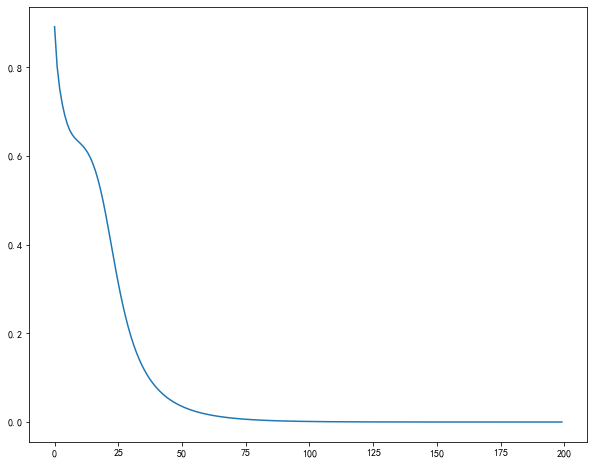

In [13]:
model = BNet()
epochs = 200

cat2id = {'Iris-setosa':0, 'Iris-versicolor': 1, 'Iris-virginica': 1}

scaler = pp.MinMaxScaler(feature_range=(0, 1))
x = scaler.fit_transform(x_real)
y = np.array([cat2id[_] for _ in y_real]).reshape(-1,)
# one_hot_encoder = pp.OneHotEncoder()
# y = one_hot_encoder.fit_transform(y).toarray()

loss = []
for i in range(epochs):
    loss.append(model.train(x, y))
    
plt.figure(figsize=(10, 8))
plt.plot(range(len(loss)), loss)
nn_result = model.test(x_real)

In [14]:
nn_acc = 0

for idx, pred_y in enumerate(y_real):
    # print(nn_result[idx].data, y[idx])
    if (nn_result[idx].data >= 0.5 and y[idx] == 1) or (nn_result[idx].data < 0.5 and y[idx] == 0):
        nn_acc += 1
    

nn_acc /= len(nn_result)

print(f'NN准确率：{nn_acc}')

NN准确率：0.3333333333333333
